downlaod from fashonMNIST  
put downloaded data into data/fashion

In [1]:
import tensorflow as tf
import os

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
img, label = mnist.train.next_batch(10)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

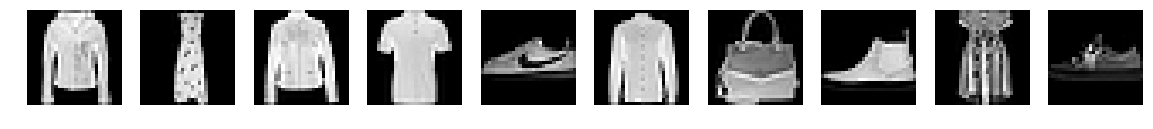

In [5]:
dim = 28
fig, axs = plt.subplots(1, len(img), figsize=(20, 3))
for i, m in enumerate(img):
        axs[i].imshow(np.reshape(m, (dim, dim)),cmap='gray')
        axs[i].axis('off')
plt.show()

In [6]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)

def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def variable_summaries(var):
   
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [7]:
image_size = 28 * 28
log_dir = "./logs"

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

with tf.name_scope('input_reshape'):    
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input',  x_image, 10)

with tf.name_scope("layer1"):
    with tf.name_scope('weights'):
        W_conv1 = weight_variable([5,5,1,32])
        variable_summaries(W_conv1)        
    with tf.name_scope('biases'):
        b_conv1 = bias_variable([32])
        variable_summaries(b_conv1)
        
with tf.name_scope("conv1"):
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    variable_summaries(h_conv1)

with tf.name_scope("pool1"):   
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("layer1"):
    with tf.name_scope('weights'):
        W_conv2 = weight_variable([5,5,32,64])
    with tf.name_scope('biases'):    
        b_conv2 = bias_variable([64])

with tf.name_scope("conv2"):
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

with tf.name_scope("pool2"):
    h_pool2 = max_pool_2x2(h_conv2)
    
with tf.name_scope("pool2_flat"):
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

with tf.name_scope("fc1"):
    with tf.name_scope('weights'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
    with tf.name_scope('biases'):   
        b_fc1 = bias_variable([1024])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

with tf.name_scope("fc2"):
    W_fc2 = weight_variable([1024,10])
    b_fc2 = bias_variable([10])

with tf.name_scope("output"):
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("loss"):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    tf.summary.scalar('cross_entropy', loss)


with tf.name_scope("opt"):
    opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope("accuracy"):
    correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [8]:
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in range(2000):
        batch = mnist.train.next_batch(50)
        opt.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
        
        if i % 100 == 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        
    test_accuracy, test_summary = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    train_writer.add_summary(test_summary, 0)
    print('test accuracy %g' % test_accuracy)

step 0, training loss 7.28293, training accuracy 0.04
step 100, training loss 0.556119, training accuracy 0.74
step 200, training loss 0.717182, training accuracy 0.76
step 300, training loss 0.332071, training accuracy 0.84
step 400, training loss 0.447119, training accuracy 0.84
step 500, training loss 0.447576, training accuracy 0.84
step 600, training loss 0.515451, training accuracy 0.8
step 700, training loss 0.485667, training accuracy 0.8
step 800, training loss 0.393036, training accuracy 0.86
step 900, training loss 0.618715, training accuracy 0.8
step 1000, training loss 0.316066, training accuracy 0.9
step 1100, training loss 0.348498, training accuracy 0.84
step 1200, training loss 0.390598, training accuracy 0.88
step 1300, training loss 0.5642, training accuracy 0.78
step 1400, training loss 0.218878, training accuracy 0.92
step 1500, training loss 0.450289, training accuracy 0.8
step 1600, training loss 0.364535, training accuracy 0.86
step 1700, training loss 0.322582,

In [9]:
with open(os.path.join(log_dir, 'metadata.tsv'),'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%d\n" % (index, np.argmax(label)))

In [10]:
rows =[]
for idx, img in enumerate(mnist.test.images):
    rows.append(np.reshape(img, [28, 28]))
columns = []
for i in range(100):
    columns.append(np.concatenate(rows[100*i:100*(i+1)], axis=0))
    
images = np.concatenate(columns, axis=1)
from scipy import misc
misc.imsave(os.path.join(log_dir, 'sprite.jpg'), images)

In [13]:
from tensorflow.contrib.tensorboard.plugins import projector

embedding_var = tf.Variable(mnist.test.images, name='embedding')
summary_writer = tf.summary.FileWriter(log_dir)

config = projector.ProjectorConfig()

embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

embedding.metadata_path = os.path.join(log_dir, 'metadata.tsv')

embedding.sprite.image_path = os.path.join(log_dir, 'sprite.jpg')
embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)

#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#saver = tf.train.Saver()
#saver.save(sess, os.path.join(log_dir, "model.ckpt"), 1)

In [14]:
embedding

tensor_name: "embedding_1:0"
metadata_path: "./logs/metadata.tsv"
sprite {
  image_path: "./logs/sprite.jpg"
  single_image_dim: 28
  single_image_dim: 28
}

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

f#rom configs import DATA_DIR, LOG_DIR, VIS_DIR
#from utils import mnist_reader
f#rom utils.helper import get_sprite_image

#X, Y = mnist_reader.load_mnist(path=DATA_DIR, kind='t10k')

#labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
#Y_str = np.array([labels[j] for j in Y])
#np.savetxt('Xtest.tsv', X, fmt='%.6e', delimiter='\t')
#np.savetxt('Ytest.tsv', Y_str, fmt='%s')

#plt.imsave('zalando-mnist-sprite.png', get_sprite_image(X), cmap='gray')

#exit()




embedding_var = tf.Variable(, name='mnist_pixels')
# Format: tensorflow/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = VIS_DIR + 'Ytest.tsv'
embedding.sprite.image_path = VIS_DIR + 'zalando-mnist-sprite.png'
# Specify the width and height of a single thumbnail.
embedding.sprite.single_image_dim.extend([28, 28])

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR + 'visualization')

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, config)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, LOG_DIR + 'visualization/model.ckpt', 0)

ModuleNotFoundError: No module named 'configs'